In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/texttoimage2k/DatasetMD/part-000001.json
/kaggle/input/texttoimage2k/DatasetMD/MD/821f19f3-5b37-4d52-8296-c581e60c1ca5.png
/kaggle/input/texttoimage2k/DatasetMD/MD/689c5ff0-8b03-475b-9e51-c34df079617e.png
/kaggle/input/texttoimage2k/DatasetMD/MD/2b569f4c-ec87-4cd1-8481-2e5db5903369.png
/kaggle/input/texttoimage2k/DatasetMD/MD/4b7a80cf-9ceb-4d64-a02b-e7ce571ab85a.png
/kaggle/input/texttoimage2k/DatasetMD/MD/41702cf8-639c-48d3-9da4-b80c8f31b186.png
/kaggle/input/texttoimage2k/DatasetMD/MD/6bd405b1-c82d-4bfa-a78e-c012786fef7b.png
/kaggle/input/texttoimage2k/DatasetMD/MD/0d6f27d3-6846-4868-ab13-432d28b9eee9.png
/kaggle/input/texttoimage2k/DatasetMD/MD/acb34c37-8bca-4eec-8403-bf2878fdcf4e.png
/kaggle/input/texttoimage2k/DatasetMD/MD/24ca1306-93bc-4d68-9dc6-cce825f1572e.png
/kaggle/input/texttoimage2k/DatasetMD/MD/5ca5c66a-5a74-4e9c-9192-6d864307dede.png
/kaggle/input/texttoimage2k/DatasetMD/MD/eb946b57-7336-44cb-a8a6-8909d5549535.png
/kaggle/input/texttoimage2k/DatasetMD/MD/04

## Import all the required libraries

In [17]:
import torch
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

# Text - Image Dataset class

In [18]:
class TextImageDataset(Dataset):
    def __init__(self, images_dir, prompt_file, transform = None):
        super().__init__()
        self.images_dir = images_dir
        self.prompt_file = open(prompt_file)
        self.prompt_data = json.load(self.prompt_file)
        self.transform = transform
        
        self.images = []
        self.prompts = []
        # i = 0
        for image in os.listdir(images_dir):
            img_path = os.path.join(images_dir, image)
            if image in self.prompt_data:
                prompt = self.prompt_data[image]['overall_caption']
                self.images.append(img_path)
                self.prompts.append(prompt)
            else:
                print(f"Warning : Image {image} found in directory but no prompt found. SKIPPING")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        prompt = self.prompts[idx]
        
        #image = np.array(Image.open(img_path).convert("RGB"))
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            #image = self.transform(image = image)
            image = self.transform(image)
        return image, prompt

## Plot some examples along with text

In [19]:
# Example usage
images_dir = "/kaggle/input/face-captions/Dataset/image"  # Replace with your actual directory
prompt_json = "/kaggle/input/face-captions/Dataset/captions_hq.json"  # Replace with your actual file
dataset = TextImageDataset(images_dir, prompt_json)


Prompt 0: This person in her thirties has no fringe, a mild smile, and no eyeglasses.


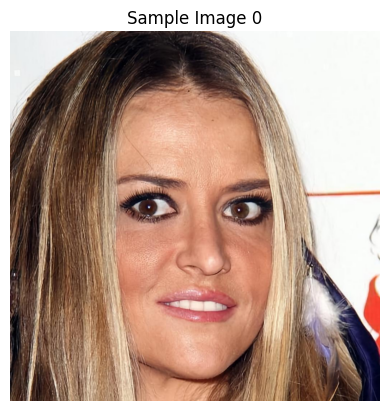

--------------------------------------------------------------------------------------------------------
Prompt 1: She has no smile, no glasses, and no bangs. This lady is a teenager.


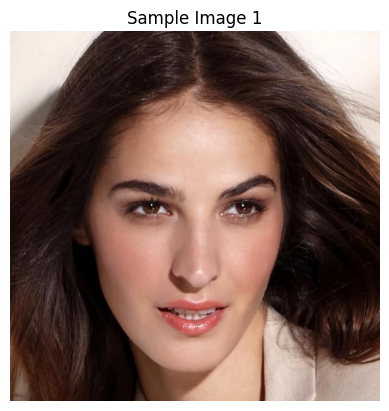

--------------------------------------------------------------------------------------------------------
Prompt 2: This person has no smile, no fringe, beard of medium length, and no eyeglasses. He is in his thirties.


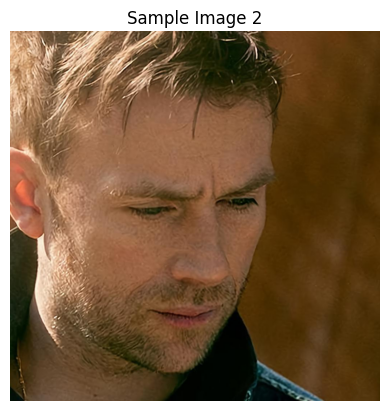

--------------------------------------------------------------------------------------------------------
Prompt 3: This young adult has no glasses, no fringe, a extremely mild smile, and beard of medium length.


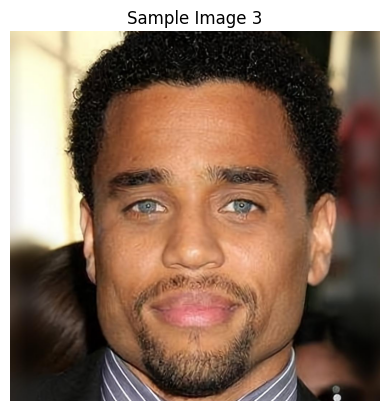

--------------------------------------------------------------------------------------------------------
Prompt 4: This young boy has no smile, no glasses, and no beard. This guy has no bangs at all.


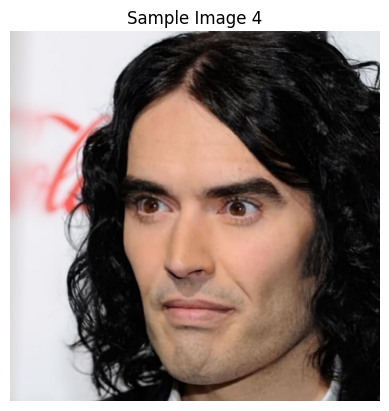

--------------------------------------------------------------------------------------------------------


In [20]:

# Check if dataset is empty
if len(dataset) == 0:
    print("Error: Dataset is empty. Please ensure images and prompts are paired correctly.")
    exit()

# Get a sample (image, prompt) pair
len_ = len(dataset)
for i in range(5):
    idx = random.randint(1, len_)
    sample_image, sample_prompt = dataset[idx]

    # Print the prompt
    print(f"Prompt {i}:", sample_prompt)

    # Display the image (assuming you want to see it visually)
    plt.imshow(sample_image)
    plt.title(f"Sample Image {i}")
    plt.axis("off")
    plt.show()
    print("--------------------------------------------------------------------------------------------------------")

### Utility functions

In [21]:
### UTILS

def get_loaders(
    image_dir,
    prompt_json,
    transform,
    batch_size,
    num_workers,
    pin_memory = True
):
    dataset = TextImageDataset(images_dir=image_dir,
                                prompt_file=prompt_json,
                                transform=transform)
    train_size = int(0.8*len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = num_workers, pin_memory = pin_memory)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = num_workers, pin_memory = pin_memory)


    return train_loader, val_loader

def save_encoder_decoder_weights(model, encoder_file_path, decoder_file_path):
    """
    Saves the weights of the encoder and decoder of a VAE model to separate files.

    Args:
    model: The VAE model instance.
    encoder_file_path: The path to save the encoder weights.
    decoder_file_path: The path to save the decoder weights.
    """
    # Get the state dictionary of the entire model
    model_state_dict = model.state_dict()

    # Separate the encoder and decoder weights
    encoder_state_dict = {}
    decoder_state_dict = {}
    for key, value in model_state_dict.items():
        if key.startswith("encoder"):
            encoder_state_dict[key[len("encoder."):]] = value
        elif key.startswith("decoder"):
            decoder_state_dict[key[len("decoder."):]] = value

        # Save the weights to separate files
        torch.save(encoder_state_dict, encoder_file_path)
        torch.save(decoder_state_dict, decoder_file_path)

        print(f"Encoder weights saved to: {encoder_file_path}")
        print(f"Decoder weights saved to: {decoder_file_path}")

def vae_loss(mse_loss, mu, logvar):
    mse_loss = mse_loss
    
    
    return mse_loss + kld_loss

In [22]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape 
        
        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape 

        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head) 

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)
        
        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1) 
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf) 
        
        # Divide by d_k (Dim / H). 
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head) 

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1) 

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2) 

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape) 

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output) 
        
        # (Batch_Size, Seq_Len, Dim)
        return output

class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads
    
    def forward(self, x, y):
        # x (latent): # (Batch_Size, Seq_Len_Q, Dim_Q)
        # y (context): # (Batch_Size, Seq_Len_KV, Dim_KV) = (Batch_Size, 77, 768)

        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        # Divide each embedding of Q into multiple heads such that d_heads * n_heads = Dim_Q
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)
        
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        q = self.q_proj(x)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        k = self.k_proj(y)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        v = self.v_proj(y)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        q = q.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        k = k.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        v = v.view(interim_shape).transpose(1, 2) 
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) @ (Batch_Size, H, Dim_Q / H, Seq_Len_KV) -> (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = q @ k.transpose(-1, -2)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight /= math.sqrt(self.d_head)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = F.softmax(weight, dim=-1)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV) @ (Batch_Size, H, Seq_Len_KV, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        output = weight @ v
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H)
        output = output.transpose(1, 2).contiguous()
        
        # (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = output.view(input_shape)
        
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len_Q, Dim_Q)
        return output

In [23]:
class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)
    
    def forward(self, x):
        # x: (Batch_Size, Features, Height, Width)

        residue = x 

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)

        n, c, h, w = x.shape
        
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w))
        
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features). Each pixel becomes a feature of size "Features", the sequence length is "Height * Width".
        x = x.transpose(-1, -2)
        
        # Perform self-attention WITHOUT mask
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention(x)
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)
        
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))
        
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width) 
        x += residue

        # (Batch_Size, Features, Height, Width)
        return x 

In [24]:
import torch
from torch import nn
from torch.nn import functional as F
class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self, x):
        # x: (Batch_Size, In_Channels, Height, Width)

        residue = x

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = self.groupnorm_1(x)
        
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = F.silu(x)
        
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.conv_1(x)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.groupnorm_2(x)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = F.silu(x)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.conv_2(x)
        
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return x + self.residual_layer(residue)


# Build the model
## Starting with VAE_Encoder
 Input: image as tensor (x)

Output: latent representation(z), mu, logvar

In [25]:
import torch
from torch import nn
from torch.nn import functional as F
# from decoder import VAE_AttentionBlock, VAE_ResidualBlock

class VAE_Encoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (Batch_Size, Channel, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            
             # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(64, 64),
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(64, 64),
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height / 2, Width / 2)
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),
            
            # (Batch_Size, 128, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(64, 128), 
            
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(128, 128), 
            
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 4, Width / 4)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0), 
            
            # (Batch_Size, 256, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(128, 256), 
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(256, 256), 
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(256, 256), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(256, 256), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
#             VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(256), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(256, 256), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.GroupNorm(32, 256), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.SiLU(), 

            # Because the padding=1, it means the width and height will increase by 2
            # Out_Height = In_Height + Padding_Top + Padding_Bottom
            # Out_Width = In_Width + Padding_Left + Padding_Right
            # Since padding = 1 means Padding_Top = Padding_Bottom = Padding_Left = Padding_Right = 1,
            # Since the Out_Width = In_Width + 2 (same for Out_Height), it will compensate for the Kernel size of 3
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8). 
            nn.Conv2d(256, 8, kernel_size=3, padding=1), 

            # (Batch_Size, 8, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8)
            nn.Conv2d(8, 8, kernel_size=1, padding=0), 
        )

    def forward(self, x):
        # x: (Batch_Size, Channel, Height, Width)
        # noise: (Batch_Size, 4, Height / 8, Width / 8)

        for module in self:

            if getattr(module, 'stride', None) == (2, 2):  # Padding at downsampling should be asymmetric (see #8)
                # Pad: (Padding_Left, Padding_Right, Padding_Top, Padding_Bottom).
                # Pad with zeros on the right and bottom.
                # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Channel, Height + Padding_Top + Padding_Bottom, Width + Padding_Left + Padding_Right) = (Batch_Size, Channel, Height + 1, Width + 1)
                x = F.pad(x, (0, 1, 0, 1))
            
            x = module(x)
        # (Batch_Size, 8, Height / 8, Width / 8) -> two tensors of shape (Batch_Size, 4, Height / 8, Width / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)
        # Clamp the log variance between -30 and 20, so that the variance is between (circa) 1e-14 and 1e8. 
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        log_variance = torch.clamp(log_variance, -30, 20)
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        variance = log_variance.exp()
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        stdev = variance.sqrt().to(DEVICE)
        mean = mean.to(DEVICE)
        # Transform N(0, 1) -> N(mean, stdev) 
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        noise = torch.randn(mean.shape).to(DEVICE)
        x = mean + stdev * noise
        
        # Scale by a constant
        # Constant taken from: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L17C1-L17C1
        x *= 0.18215
        
        return x, mean, stdev


In [26]:
class VAE_Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
            nn.Conv2d(4, 4, kernel_size=1, padding=0),

            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(4, 256, kernel_size=3, padding=1),
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(256, 256), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(256), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
#             VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(256, 256), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(256, 256), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
#             VAE_ResidualBlock(512, 512), 
            
            # Repeats the rows and columns of the data by scale_factor (like when you resize an image by doubling its size).
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 4, Width / 4)
            nn.Upsample(scale_factor=2),
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            nn.Conv2d(256, 256, kernel_size=3, padding=1), 
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(256, 256), 
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(256, 256), 
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
#             VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 2, Width / 2)
            nn.Upsample(scale_factor=2), 
            
            # (Batch_Size, 512, Height / 2, Width / 2) -> (Batch_Size, 512, Height / 2, Width / 2)
            nn.Conv2d(256, 256, kernel_size=3, padding=1), 
            
            # (Batch_Size, 512, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 128), 
            
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(128, 128), 
            
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(128, 128), 
            
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height, Width)
            nn.Upsample(scale_factor=2), 
            
            # (Batch_Size, 256, Height, Width) -> (Batch_Size, 256, Height, Width)
            nn.Conv2d(128, 128, kernel_size=3, padding=1), 
            
            # (Batch_Size, 256, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 64), 
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(64, 64), 
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(64, 64), 
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.GroupNorm(32, 64), 
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.SiLU(), 
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 3, Height, Width)
            nn.Conv2d(64, 3, kernel_size=3, padding=1), 
        )

    def forward(self, x):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        
        # Remove the scaling added by the Encoder.
        x /= 0.18215

        for module in self:
            x = module(x)

        # (Batch_Size, 3, Height, Width)
        return x

In [27]:
# class VAE_Encoder(nn.Module):
#     def __init__(self, in_dim = 3, latent_dim = 1024):
#         super(VAE_Encoder, self).__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Conv2d(in_dim, 32, kernel_size = 3, stride = 2, padding = 1),
#             nn.BatchNorm2d(num_features = 32),
#             nn.LeakyReLU(),
# #             nn.Conv2d(32, 32, kernel_size = 3, stride = 2, padding = 1),
# #             nn.BatchNorm2d(num_features = 32),
# #             nn.LeakyReLU(),
#             VAE_ResidualBlock(32, 32),
#             nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1),
#             nn.BatchNorm2d(num_features = 64),
#             nn.LeakyReLU(),
# #             nn.Conv2d(64, 64, kernel_size = 3, stride = 2, padding = 1),
# #             nn.BatchNorm2d(num_features = 64),
# #             nn.LeakyReLU(),
#             VAE_AttentionBlock(64),
#             nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
#             nn.BatchNorm2d(num_features =128),
#             nn.LeakyReLU(),
#             VAE_ResidualBlock(128, 128),
#             nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1),
#             nn.BatchNorm2d(num_features = 128),
#             nn.LeakyReLU(),
#             VAE_AttentionBlock(128),
#             nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
# #             nn.SiLU(),
# #             nn.Conv2d(256, 256, kernel_size = 4, stride = 1, padding = 2),
#             nn.BatchNorm2d(num_features = 256),
#             nn.LeakyReLU()
#         )
        
#         self.fc1 = nn.Linear(256*4*4, 512)
#         self.fc_mu = nn.Linear(512, latent_dim)
#         self.fc_log_var = nn.Linear(512, latent_dim)
        
#     def reparameterize(self, mu, log_var):
#         """
#         :param mu: mean from the encoder's latent space
#         :param log_var: log variance from the encoder's latent space
#         """
#         std = torch.exp(0.5*log_var) # standard deviation
#         eps = torch.randn_like(std) # `randn_like` as we need the same size
#         sample = mu + (eps * std) # sampling
#         return sample
    
#     def forward(self, x):
#         x = self.encoder(x)
#         x = torch.flatten(x, start_dim=1)
#         hidden = self.fc1(x)
#         mu = self.fc_mu(hidden)
#         log_var = self.fc_log_var(hidden)
        
#         z = self.reparameterize(mu, log_var)
#         return z, mu, log_var

## Following the model with VAE_Decoder
Input: latent representation(z)

Output: reconstructed_image as tensor (x)

In [28]:
# class VAE_Decoder(nn.Module):
#     def __init__(self, out_channels = 3, latent_dim = 1024):
#         super(VAE_Decoder, self).__init__()
#         self.fc = nn.Linear(latent_dim, 256*8*8)
#         self.decoder = nn.Sequential(
#             # nn.ConvTranspose2d(in_channels = 256, out_channels = 256, kernel_size = 4, stride = 2),
#             # nn.SiLU(),
#             nn.ConvTranspose2d(in_channels = 256, out_channels = 128,kernel_size=3,stride = 2,padding=1,output_padding=1),
#             nn.BatchNorm2d(num_features = 128),
#             nn.LeakyReLU(),
# #             nn.ConvTranspose2d(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2),
# #             nn.BatchNorm2d(num_features = 128),
# #             nn.LeakyReLU(),
#             VAE_AttentionBlock(128),
#             nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=3,stride = 2,padding=1,output_padding=1),
#             nn.BatchNorm2d(num_features = 64),
#             nn.LeakyReLU(),
# #             nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = 4, stride = 2),
# #             nn.BatchNorm2d(num_features = 64),
# #             nn.LeakyReLU(),
#             VAE_AttentionBlock(64),
#             nn.ConvTranspose2d(in_channels = 64, out_channels = 32,kernel_size=3,stride = 2,padding=1,output_padding=1),
#             nn.BatchNorm2d(num_features = 32),
#             nn.LeakyReLU(),
#             VAE_ResidualBlock(32, 32),
# #             nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 4, stride = 2),
# #             nn.BatchNorm2d(num_features = 32),
# #             nn.LeakyReLU(),
#             nn.ConvTranspose2d(in_channels = 32, out_channels = out_channels, kernel_size = 3, stride = 2,padding = 1, output_padding = 1),
#             nn.Sigmoid()
#         )
        
#     def forward(self, z):
#         z = self.fc(z)
#         z = z.view(-1, 256, 8, 8)
#         x_recon = self.decoder(z)
#         return x_recon

Example to test model

In [31]:
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# import math
# inp = torch.randn(32, 3, 128, 128)
# enc = VAE_Encoder()
# z, mu, logvar = enc(inp)
# dec = VAE_Decoder()
# x_recon = dec(z)
# print(f"Input shape: {inp.shape}\nLatent_z shape: {z.shape}\nReconstructed shape: {x_recon.shape}")

In [32]:
from torchvision import transforms
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# transform = A.Compose(
#         [
#             A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
#             A.Normalize(
#                 mean=[0.0, 0.0, 0.0],
#                 std = [1.0, 1.0, 1.0],
#                 max_pixel_value=255.0
#             ),
#             ToTensorV2()
#         ]
#     )
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(148),
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
    ]
)


In [33]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VAE_Encoder()
        self.decoder = VAE_Decoder()
        
    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        recon_x = self.decoder(z)
        
        return z, mu, logvar, recon_x
    

# Training and Validation Loop

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters
learning_rate = 1e-3
batch_size = 32
epochs = 7

# Create model instances
encoder = VAE_Encoder().to(DEVICE)
decoder = VAE_Decoder().to(DEVICE)
vae = VAE().to(DEVICE)
# Define loss function (e.g., Reconstruction loss + KL Divergence)
reconstruction_loss = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
optimizer = torch.optim.Adam(vae.parameters(), lr = learning_rate)
# Create dataloader from your dataset
train_loader, val_loader = get_loaders(images_dir, prompt_json,transform, batch_size = 32, num_workers = 2)


In [ ]:
def vae_loss(mse_loss, mu, logvar):
    mse_loss = mse_loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return mse_loss + 1e-5*(kld_loss).mean()

In [ ]:
mu = torch.randn(32, 4, 16, 16)
logvar = torch.randn(32, 4, 16, 16)
mse = 0.02
vae_loss(mse, mu, logvar)

In [ ]:
# Training loop
train_losses = []
val_losses = []
for epoch in range(epochs):
    print(f"----------Epoch: {epoch}----------")
    loop = tqdm(train_loader)
    train_loss = []
    mse_over = []
    for batch_idx, (images, prompts) in enumerate(loop):
        #print(images.shape)
        #images = images["image"]
        images = images.to(DEVICE)
        
        images = images.float()
        encoder.train()
        decoder.train()
#         latent_z, mu, logvar = encoder(images)
#         recon_images = decoder(latent_z)
        vae.train()
        z,mu, logvar, recon_images = vae(images)
        
        mse_loss = reconstruction_loss(images, recon_images)
        mse_over.append(mse_loss)
        loss = vae_loss(mse_loss, mu, logvar)
        train_loss.append(loss.to("cpu").detach().numpy())
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("mse: ", (sum(mse_over))/len(mse_over))
    train_losses.append((sum(train_loss))/len(train_loss))
    
    
    encoder.eval()
    decoder.eval()
    vae.eval()
    with torch.inference_mode():
        loop = tqdm(val_loader)
        val_loss = []
        for batch_idx, (images, prompts) in enumerate(loop):
            #images = images["image"]
            images = images.to(DEVICE)
            
            images = images.float()
#             latent_z, mu, logvar = encoder(images)
#             recon_images = decoder(latent_z)
            z,mu, logvar, recon_images = vae(images)
            
            mse_loss = reconstruction_loss(images, recon_images)
            loss = vae_loss(mse_loss, mu, logvar)
            val_loss.append(loss.to("cpu").detach().numpy())
        val_losses.append((sum(val_loss))/len(val_loss))
    
    print(f"VAE_Train_Loss: {train_losses[-1]:.3f}\nVAE_Val_Loss: {val_losses[-1]:.3f}")
        
# Save encoder and decoder weights separately
# save_encoder_decoder_weights(encoder, "vae_encoder_weights.pth", "vae_decoder_weights.pth")
torch.save(vae.encoder.state_dict(), "/kaggle/working/vae_encoder.pth")
torch.save(vae.decoder.state_dict(), "/kaggle/working/vae_decoder.pth")

print("Training complete! Weights saved.")

### Plot train_loss and val_loss

In [ ]:
plt.plot(range(2, len(train_losses) + 1), train_losses[1:], marker='o', linestyle='-')
plt.plot(range(2, len(val_losses) + 1), val_losses[1:], marker='*', linestyle='--')  # Use '--' for the linestyle
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.grid(False)
plt.show()


In [ ]:
from torchvision.utils import save_image

In [ ]:
save_image(images[1], f'/kaggle/working/imageorig.jpg')

In [ ]:
save_image(recon_images[1], f'/kaggle/working/imagerecons.jpg')